SVM : Support Vector machine
- Basic explanation. Drawing a line or hyperplane through classes on a dataset

- Here we will use a data set from Kaggle. This is a credit card fraud dataset from the following link : [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [2]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC

In [3]:
data = pd.read_csv('DataSets/creditcard.csv') # CC fraud data
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Each row in the above data set represents a credit card transaction. As shown above, each row has 31 variables. One variable (the last variable in the table above) is called Class and represents the target variable.
- Note: For confidentiality reasons, the original names of most features are anonymised V1, V2 etc. The values of these features are the result of a PCA transformation and are numerical. The feature 'Class' is the target variable and it takes two values: 1 in case of fraud and 0 otherwise. For more information about the dataset please check out the details on : https://www.kaggle.com/mlg-ulb/creditcardfraud.

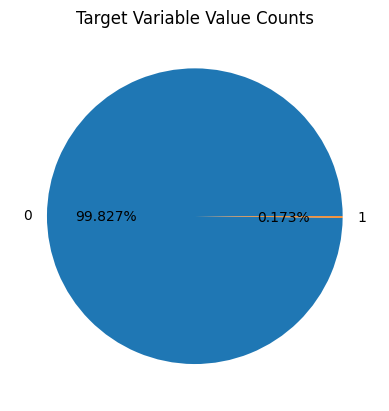

In [4]:
labels = data.Class.unique()

# get the counts of each class
sizes = data.Class.value_counts().values

fix, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As we can see 1 is fraudulent and 0 is legitimate, so classification is needed. The data is very unbalanced so we need to pay more attention to this fact. One way we can aid the model is to bias the model to pay more attention to the samples in the minority class.

Also it is important to see what features have the greatest effect.

<Axes: >

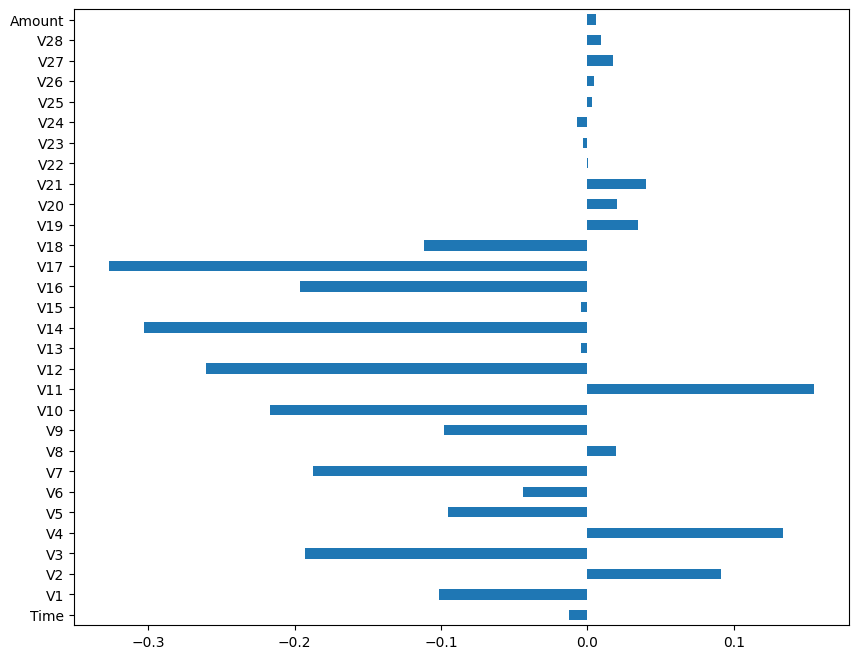

In [5]:
correlation = data.corr()['Class'].drop('Class')
correlation.plot(kind='barh', figsize = (10,8))

This clearly shows some features have a far greater impact on the output class than others. We should use only the most correlated features for efficient modeling.

# Preprocessing Data


Now we have to get the data ready for training. We will use standard scaling here with L1 norm. (Scaling row totals to 1)

In [6]:
# standardise the features by removing the mean and scaling to unit variance
data.iloc[:, 1:30] = StandardScaler().fit_transform(data.iloc[:, 1:30])
data_matrix = data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
# X = data_matrix[:, 1:30]
X = data_matrix[:, [3, 10, 12, 14, 16, 17]] # updated with the question at bottom of page
# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# Train/ Test Split


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Now we build our Decision Tree Classifier model with Scikit-Learn

In [8]:
# We will compute sample weights to be used as input so it takes into the account the imbalance in the dataset
w_train = compute_sample_weight('balanced', y_train)

With these sample weights we can now train

In [9]:
# random state for reproducible output across multiple function calls
dt = DecisionTreeClassifier(max_depth=4, random_state=35)

dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

# Support Vector Machine model with Scikit-Learn

In [10]:
# balanced gives importance to minority class, hinge tries to maximise the margin between classes, and we dont learn an intercept as our data is scaled.
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

svm.fit(X_train, y_train)

C:\Users\Patri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

Now its time to evaluate our models

- Decision Tree

In [11]:
# computes the probabilities of the test samples that belong to the class of fraudulent transactions. Needed for ROC
y_pred_dt = dt.predict_proba(X_test)[:,1]

Below compares the "y_test" which are true labels with the predicted labels , "y_pred_dt"

In [12]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.952


This means there is a 95% chance this model will rank a random positive (fraud) higher than a random negative (not fraud)

so 95% of the time , if i have 2 cases, the fraudulent one will be ranked higher

- Support Vector Machine

In [13]:
y_pred_svm = svm.decision_function(X_test)

In [14]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.937


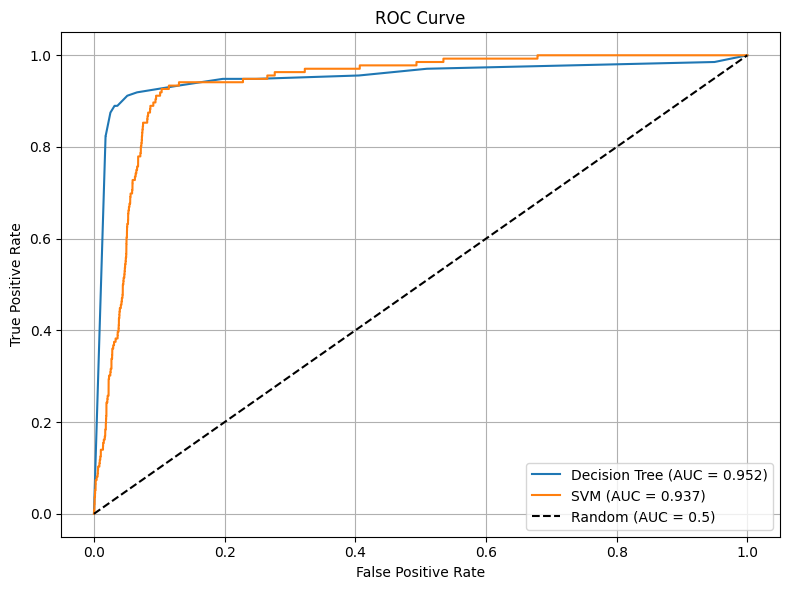

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = {:.3f})'.format(roc_auc_dt))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.3f})'.format(roc_auc_svm))

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import nbformat

with open("SVM.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

with open("SVM_github_compatible.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(nb, f)


NBFormatError: Unsupported nbformat version 5

In [17]:
!pip install --upgrade nbformat



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import nbformat

with open("SVM.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=5)  # now supported

with open("SVM_github_compatible.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(nb, f)


NBFormatError: Unsupported nbformat version 5

In [19]:
jupyter nbconvert --to notebook --NotebookExporter.nbformat_version=4 SVM.ipynb --output=SVM_fixed.ipynb


SyntaxError: invalid syntax (2380945757.py, line 1)